In [5]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [7]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [8]:
# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.90 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=32, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=32, shuffle=False)

In [167]:
# First Model
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.001)
losses, model, val_losses, val_accuracies = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=150, seed=42, verbose=False, return_val=True, test_loader=iris_test_loader)
print(f"{losses[-5:]}")

All seeds set to: 42
Model weights initialized with seed: 42
[0.06235564276576042, 0.06213986761868, 0.06200886219739914, 0.06192173585295677, 0.06178090199828148]


In [168]:
print_training_history(losses, val_losses, val_accuracies, show_last_n=10)

Training Losses (last 10 epochs):
Epoch 141: Train Loss = 0.062873, Val Loss = 0.005525, Val Acc = 1.0000
Epoch 142: Train Loss = 0.062739, Val Loss = 0.005560, Val Acc = 1.0000
Epoch 143: Train Loss = 0.062623, Val Loss = 0.005526, Val Acc = 1.0000
Epoch 144: Train Loss = 0.062567, Val Loss = 0.005398, Val Acc = 1.0000
Epoch 145: Train Loss = 0.062456, Val Loss = 0.005317, Val Acc = 1.0000
Epoch 146: Train Loss = 0.062356, Val Loss = 0.005318, Val Acc = 1.0000
Epoch 147: Train Loss = 0.062140, Val Loss = 0.005333, Val Acc = 1.0000
Epoch 148: Train Loss = 0.062009, Val Loss = 0.005297, Val Acc = 1.0000
Epoch 149: Train Loss = 0.061922, Val Loss = 0.005295, Val Acc = 1.0000
Epoch 150: Train Loss = 0.061781, Val Loss = 0.005211, Val Acc = 1.0000


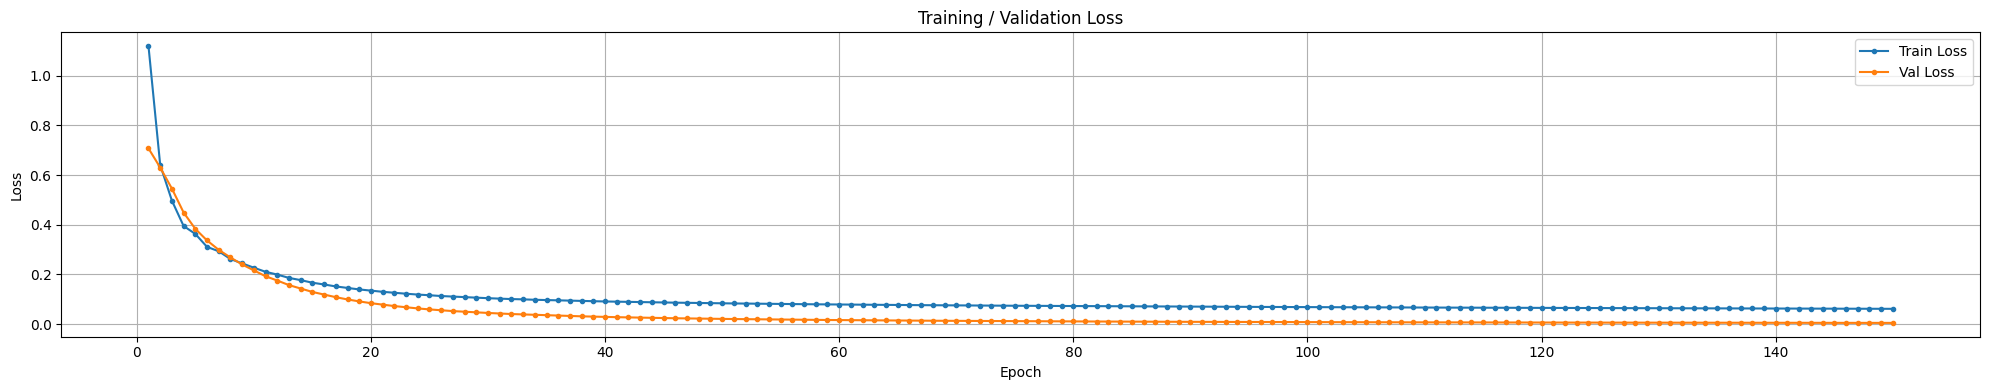

In [169]:
plot_training_history(losses, val_losses, val_accuracies, figsize=(20,4))

In [170]:
base_epochs = 150
extra_epochs = 1
index = 0
k = 5

# First Model
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.001)
iris_losses_base, trained_iris_base = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=base_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_model2 = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer_v2 = optim.Adam(iris_model2.parameters(), lr=0.001)
iris_losses_base, trained_iris2 = train_model(iris_model2, iris_train_loader, iris_criterion, iris_optimizer_v2, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_inputs, iris_activations, iris_outputs = get_activations(trained_iris_base, iris_train_loader, dataset_type='iris')
single_iris_inputs, single_iris_activations, single_iris_outputs = get_activations(trained_iris_base, iris_test_loader, dataset_type='iris', indices=index)
indices_iris, distances_iris = find_knn(iris_activations, single_iris_activations, k=k, metric='l2')
filtered_iris_loader, filtered_size = create_filtered_dataloader(iris_train_loader, exclude_indices=indices_iris, batch_size=32, shuffle=False)

iris_model3 = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer_filter = optim.Adam(iris_model3.parameters(), lr=0.001)
iris_losses_base, trained_iris_filter = train_model(iris_model3, iris_train_loader, iris_criterion, iris_optimizer_filter, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_losses_base, trained_iris_filter = train_model(iris_model3, filtered_iris_loader, iris_criterion, iris_optimizer_filter, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)
print(f"{iris_losses_base[-1:]}")

All seeds set to: 42
Model weights initialized with seed: 42
[0.06235564276576042, 0.06213986761868, 0.06200886219739914, 0.06192173585295677, 0.06178090199828148]
All seeds set to: 42
Model weights initialized with seed: 42
[0.06213986761868, 0.06200886219739914, 0.06192173585295677, 0.06178090199828148, 0.06169118396937847]
All seeds set to: 42
Model weights initialized with seed: 42
[0.06213986761868, 0.06200886219739914, 0.06192173585295677, 0.06178090199828148, 0.06169118396937847]
[0.05650508748367429]


In [171]:
predictions_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris_base, iris_test_loader, dataset_type='iris', indices=index)  # Single index
predictions_iris_v2, probabilities_iris_v2, predicted_classes_iris_v2, sample_targets_iris_v2 = predict_and_show(trained_iris2, iris_test_loader, dataset_type='iris', indices=index)  # Single index
predictions_iris__filter, probabilities_iris__filter, predicted_classes_iris__filter, sample_targets_iris_filter = predict_and_show(trained_iris_filter, iris_test_loader, dataset_type='iris', indices=index)  # Single index

print(f"{nn.CrossEntropyLoss()(predictions_iris, sample_targets_iris):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_iris_v2, sample_targets_iris_v2):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_iris__filter, sample_targets_iris_filter):.8f}")
print(f"Difference: {nn.CrossEntropyLoss()(predictions_iris__filter, sample_targets_iris_filter).item() - nn.CrossEntropyLoss()(predictions_iris_v2, sample_targets_iris_v2).item():.8f}")

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.9984      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.9985      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.9989      
0.00159196
0.00154864
0.00114471
Difference: -0.00040393


In [188]:
# Function to calculate CrossEntropy loss for different k and indices (Iris version)
def calculate_cross_entropy_for_k_and_indices(base_model, train_loader, test_loader, list_of_k, list_of_indices, base_epochs=base_epochs, extra_epochs=extra_epochs):
    """
    For each k and index:
      - find k nearest neighbors for the test sample using activations from the base model
      - create a filtered dataloader excluding those k neighbours
      - train a fresh IrisNet on the full training set for `base_epochs`
      - continue training that fresh model for `extra_epochs` on the filtered set
      - evaluate cross-entropy on the test sample and store the loss

    Returns a dict with keys 'closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy', each mapping k -> list of losses (one per index).
    """
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    # Ensure we have the base activations available (from previous cell)
    try:
        activations_ref = iris_activations
    except NameError:
        # fall back to iris_activations if present
        activations_ref = globals().get('iris_activations', None)
        if activations_ref is None:
            raise RuntimeError("iris_activations_base not found. Run the activation capture cell first.")

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        for index in list_of_indices:
            # Get activations for the single test sample
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='iris', indices=index)

            # Find k-nearest neighbors across the training activations (get full ranking, then take top-k)
            indices_knn, _ = find_knn(activations_ref, single_activations, k=len(activations_ref), metric='l2')

            closest_indices = indices_knn[:k]
            last_indices = indices_knn[-k:]
            random_indices = np.random.choice(indices_knn, k, replace=False)

            for subset_name, subset_indices in zip(['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'], [closest_indices, last_indices, random_indices]):
                # Create filtered dataloader excluding the chosen neighbors
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

                # Create and train a fresh model to the base point
                fresh_model = IrisNet()
                optimizer_tmp = optim.Adam(fresh_model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss()

                train_model(fresh_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # Continue training for extra_epochs on the filtered dataset
                if extra_epochs > 0:
                    train_model(fresh_model, filtered_loader, criterion, optimizer_tmp, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)

                # Predict and calculate CrossEntropy loss for the single test sample
                predictions, _, _, targets = predict_and_show(fresh_model, test_loader, dataset_type='iris', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name][k].append(cross_loss)

    return cross_results

In [189]:
list_of_k = list(range(1, 101, 10))
#list_of_k = [1, 5, 10, 50, 100, 250]

list_of_indices = list(range(1, 15, 1))
random_indices = random.sample(list_of_indices, k=10)

In [190]:
random_indices

[11, 2, 1, 5, 4, 10, 3, 6, 12, 14]

In [191]:
cross_results = calculate_cross_entropy_for_k_and_indices(trained_iris_base, iris_train_loader, iris_test_loader, list_of_k, random_indices)

# Save random_indices to a file
with open('stored_data/random_indices_150_l2.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('stored_data/cross_results_150_l2.pkl', 'wb') as f:
    pickle.dump(cross_results, f)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
11     virginica    virginica    0.9953      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
11     virginica    virginica    0.9953      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
11     virginica    virginica    0.9953      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
-----------

In [195]:
random_indices

[11, 2, 1, 5, 4, 10, 3, 6, 12, 14]

In [196]:
cross_results['closest_cross_entropy']

{1: [0.004665204789489508,
  0.0017720249015837908,
  0.0008846183773130178,
  0.01029018685221672,
  0.019071191549301147,
  0.0001616347290109843,
  0.0007627676823176444,
  0.00012694983161054552,
  5.960462772236497e-07,
  0.0008054111385717988],
 11: [0.0049811312928795815,
  0.0022251864429563284,
  0.0011481605470180511,
  0.012324958108365536,
  0.024034570902585983,
  0.00015472168161068112,
  0.0006650857976637781,
  0.00011622230522334576,
  5.960462772236497e-07,
  0.000839238753542304],
 21: [0.0025830259546637535,
  0.0011325619416311383,
  0.0013050857232883573,
  0.012807494960725307,
  0.02522417902946472,
  0.00015984688070602715,
  0.0007784912013448775,
  0.00012396997772157192,
  5.960462772236497e-07,
  0.0011044599814340472],
 31: [0.0029948167502880096,
  0.0016468308167532086,
  0.0016432604752480984,
  0.023205148056149483,
  0.03807320073246956,
  0.00017093151109293103,
  0.0010342017048969865,
  0.0001419681793777272,
  5.960462772236497e-07,
  0.0014421073

In [183]:
# Load cross_results from a file
with open('stored_data/cross_results_150_l1.pkl', 'rb') as f:
    cross_results = pickle.load(f)

# Load random_indices from a file
with open('stored_data/random_indices_150_l1.pkl', 'rb') as f:
    random_indices = pickle.load(f)

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
11     virginica    virginica    0.9951      
Base error for index 11: 0.00492977


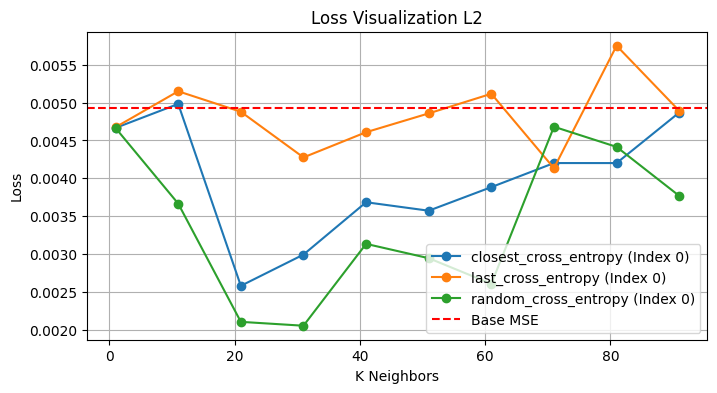

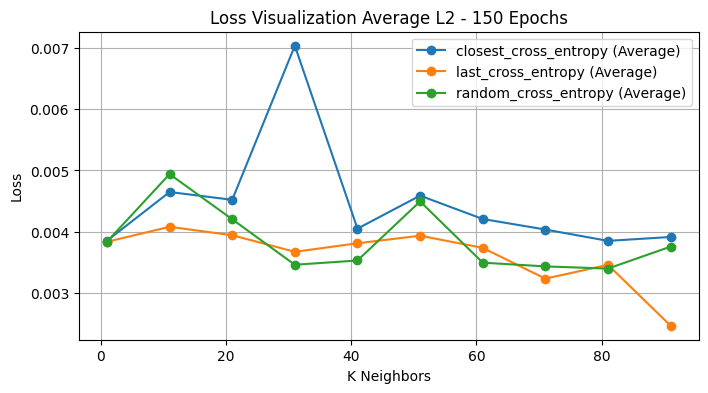

In [194]:
index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris2, iris_test_loader, dataset_type='iris', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris)
print(f"Base error for index {index_base}: {base_error:.8f}")

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title="Loss Visualization L2", ylabel="Loss", max_knn=100)
visualize_results(cross_results, random_indices, average=True, normalize=False, title="Loss Visualization Average L2 - 150 Epochs")